# Train a bert-base-uncased + custom head model with PyTorch

## Use GPU for training

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-839f9792-71e6-e457-81b7-9ff307de0c09)


In [2]:
!nvidia-smi -q -d MEMORY


==============NVSMI LOG==============

Timestamp                                 : Thu Aug 18 10:57:52 2022
Driver Version                            : 470.82.01
CUDA Version                              : 11.4

Attached GPUs                             : 1
GPU 00000000:00:04.0
    FB Memory Usage
        Total                             : 16280 MiB
        Used                              : 0 MiB
        Free                              : 16280 MiB
    BAR1 Memory Usage
        Total                             : 16384 MiB
        Used                              : 2 MiB
        Free                              : 16382 MiB



In [3]:
!pip install torchmetrics transformers torchsummary adabelief-pytorch==0.2.0

In [4]:
import numpy as np
import torch
import pandas as pd
from torch import nn
from adabelief_pytorch import AdaBelief
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertModel, BertTokenizer

from tqdm.notebook import tqdm

import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

DATA_DIR = '../input/subreddit-post-prediction/data.csv'
BERT = 'bert-base-uncased'

Using cuda device


## Global variables

In [6]:
# DataLoader params
BATCH_SIZE = 16
PIN_MEMORY = False
NUM_WORKERS = 0

# Generic params
EPOCHS = 4
LR = 5e-5
N_EVALUATIONS_PER_EPOCH = 20
N_CLASSES = 9
ACC_STEP = 4
PATIENCE = int(N_EVALUATIONS_PER_EPOCH / 4)

# AdaBelief params
WEIGHT_DECAY = 2e-4
EPS = 1e-16
RECTIFY = True

# BERT params
DIM_HIDDEN1 = 384
DIM_HIDDEN2 = 64
DIM_HIDDEN3 = 512
BERT_PATH = "bert-base-uncased"

# Tokenizer params
TOKEN_MAX_LENGTH = 120

## Data loading, preprocessing & splitting

In [7]:
data = pd.read_csv(DATA_DIR, keep_default_na = False)

In [8]:
def divide_data_labels(data):
    y = data['subreddit']
    data.drop('subreddit', inplace = True, axis = 1)
    return data, y

In [9]:
def clean_dataset(data):
    data.loc[data['selftext'].eq('[deleted]'), 'selftext'] = ''
    data.loc[data['selftext'].eq('[removed]'), 'selftext'] = ''
    
    upvote_ratio = data['upvote_ratio']
    data.drop('upvote_ratio', inplace = True, axis = 1)
    return data, upvote_ratio

In [10]:
def concat_title_selftext(data):
    data = data['title'] + ' ' + data['selftext']
    return data

In [11]:
def train_test_splitting(data, y):
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)
    return X_train, X_test, X_val, y_train, y_test, y_val

In [12]:
def encode_labels(y):
    y_string = y
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y)
    return y, y_string

In [13]:
def dataset_to_numpy(X):
    X = X.to_numpy()
    return X

In [14]:
data, y = divide_data_labels(data)

In [15]:
data, upvote_ratio = clean_dataset(data)

In [16]:
data = concat_title_selftext(data)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_splitting(data, y)

In [18]:
# Dataset params
N_TRAIN_DATA = X_train.shape[0]
N_TEST_DATA = X_test.shape[0]
N_VAL_DATA = 4096

In [19]:
y_train, y_train_string = encode_labels(y_train)
y_test, y_test_string = encode_labels(y_test)
y_val, y_val_string = encode_labels(y_val)

In [20]:
X_train = dataset_to_numpy(X_train)
X_test = dataset_to_numpy(X_test)
X_val = dataset_to_numpy(X_val)

## Torch BERT model

In [21]:
class BERTClass(nn.Module):
    def __init__(self, dim_hidden1, dim_hidden2, dim_hidden3, n_class, bert):
        super(BERTClass, self).__init__()
        
        self.dim_hidden1 = dim_hidden1
        self.dim_hidden2 = dim_hidden2
        self.dim_hidden3 = dim_hidden3
        self.n_class = n_class

        self.BERT = BertModel.from_pretrained(bert)
        self.tokenizer = BertTokenizer.from_pretrained(bert)
        
        self.dropout = nn.Dropout(0.15)
        # NOTE: BERT creates 768-dimension embeddings
        self.linear1 = nn.Linear(768, self.dim_hidden1)
        self.linear2 = nn.Linear(self.dim_hidden1, self.dim_hidden2)
        self.linear3 = nn.Linear(self.dim_hidden2, self.dim_hidden3)
        self.linear4 = nn.Linear(self.dim_hidden3, self.n_class)
        self.activation = nn.GELU()
         
    # input should be already tokenized with tokenizer
    def forward(self, input_ids, attention_mask):
        
        # torch.Size([n_sentences, max_n_tokens, encoding_size])
        x = self.BERT(input_ids=input_ids, attention_mask=attention_mask) 
        # NOTE: not all sentences have same number of tokens 
        # tokenized_input['attention_mask'] is zero when padding tokens are added
        
        x = self.mean_pooling(x, attention_mask)
        # torch.Size([n_sentences, encoding_size])

        # Mix encodings
        # dot = torch.einsum('ij,ij->i', x1, x2).unsqueeze(1) # torch.Size([n_sentences, 1])
        # diff = torch.subtract(x1, x2)                       # torch.Size([n_sentences, encoding_size])
        # x = torch.concat((dot, diff), 1)
        
        # sequence: LINEAR -> DROP -> GELU
        x = self.activation(self.dropout(self.linear1(x)))
        x = self.activation(self.linear2(x))
        x = self.activation(self.dropout(self.linear3(x)))
        x = self.activation(self.linear4(x))
        
        return x
    
    def mean_pooling(self, x, attention_mask):
        token_embeddings = x[0] #First element of BERT output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

## Torch dataloader class

In [22]:
class NLIDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        """
        Args:
            input_ids (list of tensors):      List of tokenizer's first tensors (relative to sentence)
            attention_mask (list of tensors): List of tokenizer's second tensors (relative to sentence)
            labels (list of tensors):          List of labels
            collate_fn:                        Function used to pad inputs and masks when put into batches
        """
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'label': self.labels[idx]
        }
        
        return sample   

def custom_collate(batch):
    max_length = 0
    
    # Compute length of longest sentence in batch
    for single_data_dict in batch:
        sentence_length = single_data_dict['input_ids'].shape[1]
        if sentence_length > max_length:
            max_length = sentence_length
    
    # Pad to longest sequence
    for single_data_dict in batch:
        sentence_length = single_data_dict['input_ids'].shape[1]
        if sentence_length < max_length:
            single_data_dict['input_ids'] = torch.nn.functional.pad(single_data_dict['input_ids'], (0, max_length - sentence_length), 'constant', 1)
            single_data_dict['attention_mask'] = torch.nn.functional.pad(single_data_dict['attention_mask'], (0, max_length - sentence_length), 'constant', 0)
    
    input_ids = torch.cat([single_data_dict['input_ids'] for single_data_dict in batch]).to(device)
    attention_mask = torch.cat([single_data_dict['attention_mask'] for single_data_dict in batch]).to(device)
    labels = torch.stack([single_data_dict['label'] for single_data_dict in batch]).to(device)
    
    return (input_ids, attention_mask, labels)

## Tokenization function

In [23]:
def tokenize_sentence_by_sentence(sentences, tokenizer):
    
    input_ids = []
    attention_masks = []
    max_length = 0
    
    for i in tqdm(range(len(sentences))):
        tokenized_input = tokenizer(sentences[i], padding=True, truncation=True, return_tensors='pt', max_length=TOKEN_MAX_LENGTH)
        input_ids.append(tokenized_input['input_ids'])
        attention_masks.append(tokenized_input['attention_mask'])
        
        # Calculate longest sentence in dataset
        if tokenized_input['input_ids'].shape[1] > max_length:
            max_length = tokenized_input['input_ids'].shape[1]
            
    return input_ids, attention_masks, max_length

## Dataset creation function

In [24]:
def create_dataset(sentences, labels, tokenizer):
    print('Creating Dataset...')
    torch_sentences_ids, torch_sentences_attention_masks, max_length = tokenize_sentence_by_sentence(sentences, tokenizer)
    
    torch_labels = torch.tensor(labels)

    dataset = NLIDataset(torch_sentences_ids, torch_sentences_attention_masks, torch_labels)
    print('... Dataset created!')
    return dataset, max_length

## Random sampling function

In [25]:
def random_sample(N_data, *lists, seed=1, preshuffle=False):
    N_data = min(N_data, len(lists[0]))
    if preshuffle:
        sampled_lists = []
        for arr in lists:
            random.seed(seed)
            sampled_lists.append(random.sample(arr, N_data))
        return sampled_lists
    else:
        return [partial_list[0:N_data] for partial_list in lists]

In [26]:
sentences_train, labels_train = random_sample(N_TRAIN_DATA, X_train, y_train)
sentences_test, labels_test = random_sample(N_TEST_DATA, X_test, y_test)
sentences_val, labels_val = random_sample(N_VAL_DATA, X_val, y_val)

## Initialize BERT classifier

### Warning given:
Tells that we won't have good performance with your Bert model before fine-tuning it.

In [27]:
classifier = BERTClass(DIM_HIDDEN1, DIM_HIDDEN2, DIM_HIDDEN3, N_CLASSES, BERT_PATH).to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## Create torch-compliant dataset

In [28]:
dataset_train, max_length_train = create_dataset(sentences_train, labels_train, classifier.tokenizer)
dataset_test, max_length_test = create_dataset(sentences_test, labels_test, classifier.tokenizer)
dataset_val, max_length_val = create_dataset(sentences_val, labels_val, classifier.tokenizer)

dataset_max_length = max(max_length_train, max_length_test, max_length_val)

Creating Dataset...


  0%|          | 0/382528 [00:00<?, ?it/s]

... Dataset created!
Creating Dataset...


  0%|          | 0/47816 [00:00<?, ?it/s]

... Dataset created!
Creating Dataset...


  0%|          | 0/4096 [00:00<?, ?it/s]

... Dataset created!


## Create DataLoader

In [29]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=True, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=custom_collate, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=True, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS)

## Model validation function

In [30]:
def validate_model(dataloader, classifier, loss_function, name, losses, accuracies, confusion_matrices, accuracy_metric, confusion_matrix_metric):
    
    print(name.upper())

    classifier.eval()
    loss = 0
    
    for batch in dataloader:

        input_ids, attention_masks, labels = batch

        with torch.no_grad():
            y_pred = classifier(input_ids, attention_masks)
            loss += loss_function(y_pred, labels)
            
            y_pred = torch.argmax(y_pred, dim=1)

            accuracy = accuracy_metric(y_pred, labels)
            confusion_matrix = confusion_matrix_metric(y_pred, labels)
    
    print(f'Loss: {loss}')
    
    # metric on all batches using custom accumulation
    accuracy = accuracy_metric.compute()
    print(f"Accuracy on all data: {accuracy}")

    confusion_matrix = confusion_matrix_metric.compute()
    print(f"Confusion matrix on all data:")
    print(confusion_matrix)
    
    losses.append(float(loss))
    accuracies.append(float(accuracy))
    confusion_matrices.append(confusion_matrix.cpu().numpy())
    
    # Resetting internal state to be ready for new data
    accuracy_metric.reset()
    confusion_matrix_metric.reset()

    classifier.train()
    
    return

## Model training function

In [31]:
def training(device, dataloader_train, dataloader_val, dataset_max_length, classifier, loss_function, optimizer, accuracy_metric, confusion_matrix_metric, accuracies_train, losses_train):
    
    correct = 0
    best_accuracy_train = 0
    trigger_early_stopping = 0
    n_training_data = len(dataloader_train)
    
    # Dummy forward and backward to pre-allocate memory (speed-up training and avoid mid-training errors)
    input_ids = torch.randint(classifier.tokenizer.vocab_size, (BATCH_SIZE, dataset_max_length), device=device)
    attention_mask = torch.ones((BATCH_SIZE, dataset_max_length), device=device)

    y_pred = classifier(input_ids, attention_mask)
    loss = loss_function(y_pred, torch.randint(0, N_CLASSES, (BATCH_SIZE,), device=device))
    loss.backward()
    optimizer.zero_grad()

    # TRAINING
    train_tqdm = tqdm(total = EPOCHS * n_training_data)

    n_batches_before_validation = int(n_training_data / N_EVALUATIONS_PER_EPOCH)

    for epoch in range(EPOCHS):
        print('-'* 15 + " EPOCH {} ".format(epoch) + '-' * 15)

        classifier.train()

        for i, batch in enumerate(dataloader_train):
            input_ids, attention_mask, labels = batch

            y_pred = classifier(input_ids, attention_mask)

            # n_classes-dim to 1-dim
            pred = torch.argmax(y_pred, dim = 1)

            loss = loss_function(y_pred, labels) / ACC_STEP
            loss.backward()

            correct += torch.eq(pred, labels).sum().item()

            if (i+1) % ACC_STEP == 0:
                optimizer.step() 
                optimizer.zero_grad() # Mixed precision

            train_tqdm.update(1)

            # VALIDATION
            if (i + 1) % n_batches_before_validation == 0:
                n_seen_data = BATCH_SIZE * int(i + 1 + n_training_data * epoch)
                print(f"\n--- Validation after {n_seen_data} training data ---")
                
                accuracies_train.append(correct / n_seen_data)
                losses_train.append(loss.item() * BATCH_SIZE * (N_TRAIN_DATA / N_VAL_DATA))
                print(losses_train)
                
                print(f"Accuracy on train set: {accuracies_train[-1]}")

                validate_model(
                    dataloader = dataloader_val, 
                    classifier = classifier, 
                    loss_function = loss_function, 
                    name = 'VALIDATION',
                    losses = losses,
                    accuracies = accuracies,
                    confusion_matrices = confusion_matrices,
                    accuracy_metric = accuracy_metric,
                    confusion_matrix_metric = confusion_matrix_metric
                )

                if accuracies_train[-1] < best_accuracy_train:
                    trigger_early_stopping += 1
                    print('Early stopping in:', PATIENCE - trigger_early_stopping)

                elif accuracies_train[-1] >= best_accuracy_train:
                    
                    best_accuracy_train = accuracies_train[-1]
                    trigger_early_stopping = 0
                    
                    # if training is the best, also validation needs to be the best to save model
                    if (accuracies.index(max(accuracies)) == len(accuracies) - 1):
                        print('Best model so far. Saving...')
                        torch.save(
                            {
                            'epoch': epoch,
                            'model_state_dict': classifier.state_dict(),
                            'losses': losses,
                            'accuracies': accuracies,
                            'confusion_matrices': confusion_matrices
                            }, './subreddit_classification_model.pt'
                        )
                        print('Saved model.')
                    else:
                        print('Training improves but validation does not. Model not saved.')
                    
                if trigger_early_stopping >= PATIENCE:
                    print('Early Stopping activated. Exiting training phase.')
                    return classifier.state_dict(), losses, accuracies, confusion_matrices, accuracies_train, losses_train

    return classifier.state_dict(), losses, accuracies, confusion_matrices, accuracies_train, losses_train

## Training function call cell

In [32]:
losses = []
accuracies = []
confusion_matrices = []
losses_train = []
accuracies_train = []

# Loss function, optimizer & metrics
loss_function = nn.CrossEntropyLoss()
optimizer = AdaBelief(classifier.parameters(), lr=LR, weight_decay = WEIGHT_DECAY, eps = EPS, rectify = RECTIFY)
accuracy_metric = torchmetrics.Accuracy().to(device)
confusion_matrix_metric = torchmetrics.ConfusionMatrix(num_classes=N_CLASSES).to(device)

model, losses, accuracies, confusion_matrices, accuracies_train, losses_train = training(
    device = device,
    dataloader_train = dataloader_train,
    dataloader_val = dataloader_val,
    dataset_max_length = dataset_max_length,
    classifier = classifier,
    loss_function = loss_function,
    optimizer = optimizer,
    accuracy_metric = accuracy_metric,
    confusion_matrix_metric = confusion_matrix_metric,
    accuracies_train = accuracies_train,
    losses_train = losses_train
)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


  0%|          | 0/95632 [00:00<?, ?it/s]

--------------- EPOCH 0 ---------------

--- Validation after 19120 training data ---
[270.36225049197674]
Accuracy on train set: 0.44173640167364014
VALIDATION
Loss: 297.00341796875
Accuracy on all data: 0.621826171875
Confusion matrix on all data:
tensor([[  2,  11,  16,   2,   0,   0, 166,   0,   1],
        [  0, 486,  17,  25,   0,   0,  69,  54,   3],
        [  0,  45, 535,  45,   0,   0,  54,   3,   6],
        [  0,  43,  55, 308,   0,   0,  34,  13, 165],
        [  0,  21,   1,   5,  76,   0,  17,  50,   7],
        [  0,   7,   2,   3,   0,   0,  91,   4,  10],
        [  0,  47,  11,  21,   2,   0, 425,  54,  40],
        [  0,  96,   2,  17,   0,   0,  60, 199,  43],
        [  0,   6,  10,  58,   1,   0,  17,  19, 516]], device='cuda:0')
Best model so far. Saving...
Saved model.

--- Validation after 38240 training data ---
[270.36225049197674, 244.19346215948462]
Accuracy on train set: 0.5596234309623431
VALIDATION
Loss: 235.05287170410156
Accuracy on all data: 0.700439

## Loss & accuracy plots

Text(0.5, 1.0, 'Loss function')

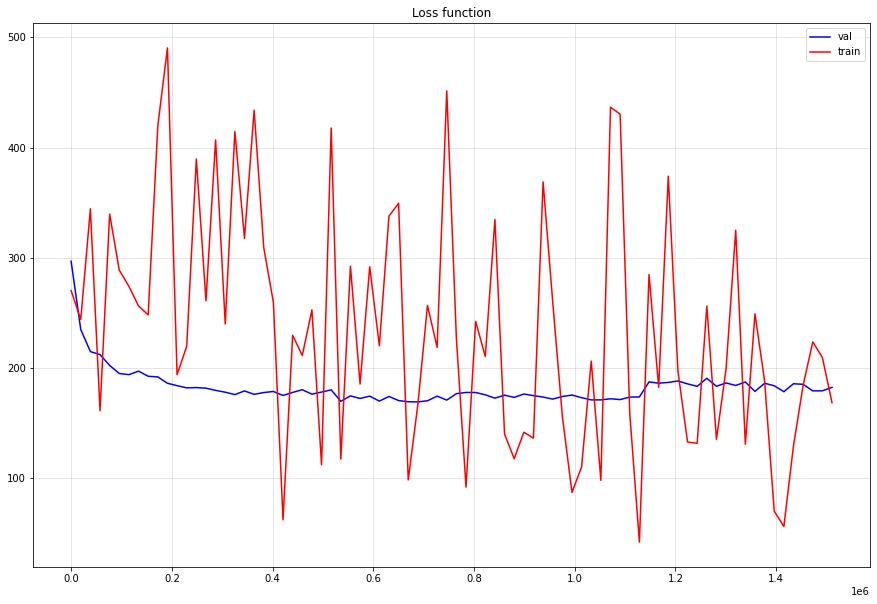

In [33]:
plt.figure(figsize = (15, 10))
plt.plot(np.arange(0, N_TRAIN_DATA * EPOCHS, ((N_TRAIN_DATA * EPOCHS) / len(losses))), losses, c = 'b', label = 'val')
plt.plot(np.arange(0, N_TRAIN_DATA * EPOCHS, ((N_TRAIN_DATA * EPOCHS) / len(losses_train))), losses_train, c = 'r', label = 'train')
plt.grid(alpha=0.4)
plt.legend()
plt.title("Loss function")

Text(0.5, 1.0, 'Accuracy')

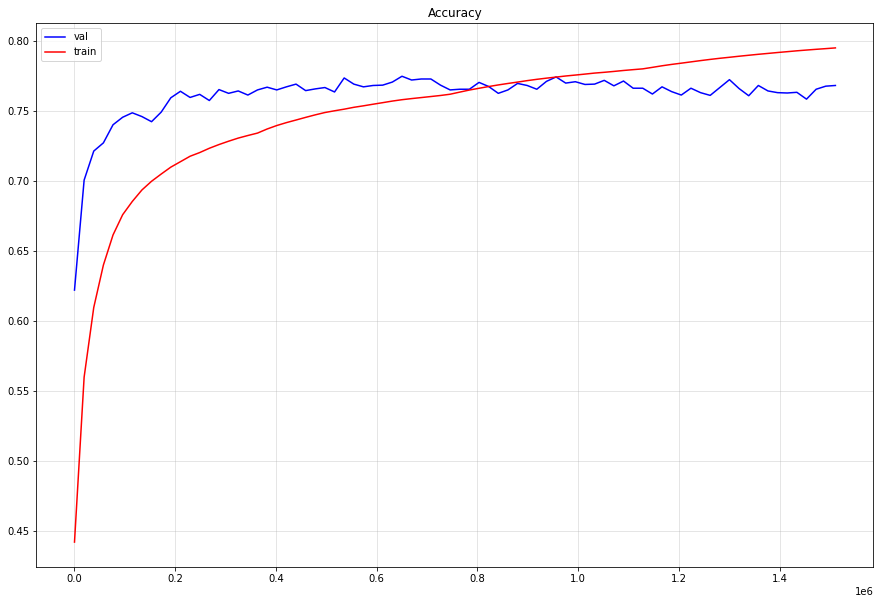

In [34]:
plt.figure(figsize = (15, 10))
plt.plot(np.arange(0, N_TRAIN_DATA * EPOCHS, ((N_TRAIN_DATA * EPOCHS) / len(accuracies))), accuracies, c = 'b', label = 'val')
plt.plot(np.arange(0, N_TRAIN_DATA * EPOCHS, ((N_TRAIN_DATA * EPOCHS) / len(accuracies_train))), accuracies_train, c = 'r', label = 'train')
plt.grid(alpha=0.4)
plt.legend()
plt.title("Accuracy")

## Model test function

In [35]:
def test(device, classifier, dataloader, name, loss_function, accuracy_metric, confusion_matrix_metric):

    print(name.upper())

    classifier.eval()
    loss = 0
    
    for batch in dataloader:

        input_ids, attention_masks, labels = batch

        with torch.no_grad():
            y_pred = classifier(input_ids, attention_masks)
            loss += loss_function(y_pred, labels)
            
            y_pred = torch.argmax(y_pred, dim=1)

            accuracy = accuracy_metric(y_pred, labels)
            confusion_matrix = confusion_matrix_metric(y_pred, labels)
    
    print(f'Loss: {loss}')
    
    # metric on all batches using custom accumulation
    accuracy = accuracy_metric.compute()
    print(f"Accuracy on all data: {accuracy}")

    confusion_matrix = confusion_matrix_metric.compute()
    print(f"Confusion matrix on all data:")
    print(confusion_matrix)
    
    return

## Model test call cell

In [36]:
test(
    device = device,
    classifier = classifier,
    dataloader = dataloader_test,
    name = 'TEST',
    loss_function = loss_function,
    accuracy_metric = accuracy_metric,
    confusion_matrix_metric = confusion_matrix_metric
)

TEST
Loss: 2086.6181640625
Accuracy on all data: 0.7794671058654785
Confusion matrix on all data:
tensor([[1752,   63,  126,   62,    5,   57,  252,   12,   12],
        [  88, 6044,  150,  275,   22,    6,  451,  459,    7],
        [  99,  123, 6876,  345,    6,    4,  115,   10,   14],
        [  38,  180,  320, 5372,    5,   15,  261,  202, 1114],
        [  16,   39,   26,   40, 1748,    4,   92,   30,   27],
        [  73,   28,   19,   50,    2,  946,  277,   11,   37],
        [ 178,  394,  112,  314,   50,  125, 5281,  607,  147],
        [  18,  769,   41,  189,   12,   11,  495, 3081,  128],
        [  11,   30,   45,  928,    8,   19,  100,  145, 6171]],
       device='cuda:0')
